In [ ]:
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#get test data
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/test_data.zip","r") as zip_ref:
    zip_ref.extractall("/content/sample_data/test_data")

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/split_dataset.zip","r") as zip_ref:
    zip_ref.extractall("/content/sample_data/split_dataset")

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.tensorboard import SummaryWriter
torch.set_printoptions(linewidth=120)

plt.ion()   # interactive mode

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(45),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'sample_data/split_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#datatransformer
data_trnsform=transforms.Compose([ transforms.Resize([224,224]),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

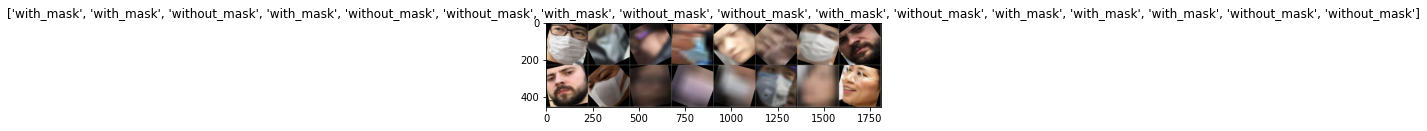

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    tb = SummaryWriter()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
model_conv = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)
w=torch.Tensor([1.1, 0.0437, 0.239]).cuda()
criterion = nn.CrossEntropyLoss(weight=w)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.9369 Acc: 0.6599
val Loss: 0.7988 Acc: 0.8096

Epoch 1/29
----------
train Loss: 0.7945 Acc: 0.7744
val Loss: 0.7440 Acc: 0.5786

Epoch 2/29
----------
train Loss: 0.7450 Acc: 0.7759
val Loss: 0.7304 Acc: 0.8894

Epoch 3/29
----------
train Loss: 0.7128 Acc: 0.7851
val Loss: 0.6637 Acc: 0.7482

Epoch 4/29
----------
train Loss: 0.6824 Acc: 0.7741
val Loss: 0.6380 Acc: 0.8735

Epoch 5/29
----------
train Loss: 0.6559 Acc: 0.8103
val Loss: 0.6674 Acc: 0.8808

Epoch 6/29
----------
train Loss: 0.6337 Acc: 0.7922
val Loss: 0.6827 Acc: 0.9017

Epoch 7/29
----------
train Loss: 0.6016 Acc: 0.8379
val Loss: 0.6203 Acc: 0.8919

Epoch 8/29
----------
train Loss: 0.5838 Acc: 0.8168
val Loss: 0.6031 Acc: 0.8894

Epoch 9/29
----------
train Loss: 0.5747 Acc: 0.8297
val Loss: 0.5722 Acc: 0.8968

Epoch 10/29
----------
train Loss: 0.5606 Acc: 0.8416
val Loss: 0.5908 Acc: 0.8845

Epoch 11/29
----------
train Loss: 0.5553 Acc: 0.8303
val Loss: 0.5810 Acc: 0.8894

Ep

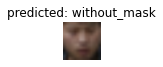

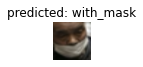

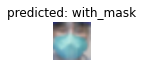

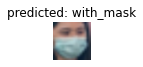

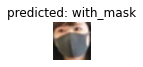

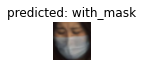

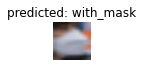

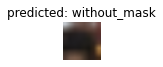

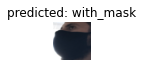

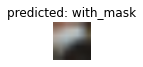

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
torch.save(model_conv, 'best-model.pt')

In [ ]:
model = torch.load('/content/drive/MyDrive/best-model.pt')
model.eval()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image

directory="/content/sample_data/test_data/test_data"
subfolders = [ f.path for f in os.scandir(directory) if f.is_dir() ]
subfolders =[os.path.relpath(x, directory) for x in subfolders ]
y=[]
y_pred=[]
for i in subfolders:
  label=i
  for x in os.listdir(os.path.join(directory, i)):
    y.append(label)
    img = Image.open(os.path.join(directory, i,x)).convert('RGB')
    img_t = data_trnsform(img)
    batch_t = torch.unsqueeze(img_t, 0).cuda()
    out=model(batch_t)
    y_pred.append(out)

In [ ]:
def classFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return class_names[category_i]

In [ ]:
yy=[classFromOutput(x) for x in y_pred]

Accuracy (Lin Kernel):  64.62
F1 (Lin Kernel):  56.49


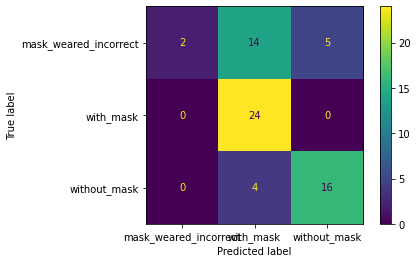

In [ ]:

accuracy = accuracy_score(y, yy)
f1 = f1_score(y, yy, average='weighted')
print('Accuracy (Lin Kernel): ', "%.2f" % (accuracy*100))
print('F1 (Lin Kernel): ', "%.2f" % (f1*100))
cm = confusion_matrix(y, yy, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.show()

In [ ]:
print(class_names)

['mask_weared_incorrect', 'with_mask', 'without_mask']
